In [ ]:
!pip install tensorflow tensorflow-probability pandas numpy matplotlib

In [ ]:
pip install bsts pandas openpyxl scikit-learn

In [ ]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import bsts  # For Bayesian structural time series models
from sklearn import model_selection, preprocessing, pipeline
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
np.random.seed(42)

In [ ]:
tb_data=pd.read_csv('/content/TB Dataset 2024.csv',index_col=0,parse_dates=True)

<ipython-input-35-3d77a2ce824e>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  tb_data=pd.read_csv('/content/TB Dataset 2024.csv',index_col=0,parse_dates=True)


In [ ]:
tb_ts = pd.Series(
    tb_data['Cases'].values,
    index=pd.date_range(start='2017-01', periods=len(tb_data), freq='M')
)

# Verify the time series
print(tb_ts.head())
print(f"Time series length: {len(tb_ts)}")

2017-01-31    144781
2017-02-28    147133
2017-03-31    176283
2017-04-30    160671
2017-05-31    161146
Freq: ME, dtype: int64
Time series length: 90


<ipython-input-36-c9d820fc673e>:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index=pd.date_range(start='2017-01', periods=len(tb_data), freq='M')


In [ ]:
# Split time series into train and test sets (80-20 split)
train_size = int(round(0.8 * len(tb_ts)))  # Calculate split point
train_ts = tb_ts.iloc[:train_size]         # First 80% of data
test_ts = tb_ts.iloc[train_size:]          # Remaining 20% of data

# Verify the split
print(f"Training set: {len(train_ts)} observations")
print(f"Test set: {len(test_ts)} observations")

Training set: 72 observations
Test set: 18 observations


In [ ]:
# Set random seed for reproducibility
tf.random.set_seed(2016)

In [ ]:
# Define the model components
observed_time_series = train_ts.values.astype(np.float32)  # Convert training data to numpy array
trend = sts.LocalLinearTrend(observed_time_series=observed_time_series)
seasonal = sts.Seasonal(num_seasons=12, observed_time_series=observed_time_series)
model = sts.Sum([trend, seasonal], observed_time_series=observed_time_series)

In [ ]:
# Fit BSTS model using MCMC
num_results = 500  # Total MCMC iterations
burn_in_percent = 0.2  # Suggested burn-in percentage (20%)
num_burnin_steps = int(burn_in_percent * num_results)  # Calculate burn-in
#samples, kernel_results = tfp.sts.fit_with_hmc(
    #model,
    #observed_time_series,
    #num_results=num_results,
    #num_burnin_steps=num_burnin_steps)
samples, kernel_results = tfp.sts.fit_with_hmc(
    model,
    observed_time_series,
    num_results=num_results,
    seed=2016  # For reproducibility
)


/usr/local/lib/python3.11/dist-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


In [ ]:
# Forecast for test period
#horizon = len(test_ts)
#predictive_dist = tfp.sts.forecast(
    #model,
    #observed_time_series,
    #parameter_samples=samples,
    #num_steps_ahead=horizon)

# Manually discard burn-in samples
burned_samples = [param[num_burnin_steps:] for param in samples]

# Forecast for test period
horizon = len(test_ts)  # Forecasting for test period length
predictive_dist = tfp.sts.forecast(
    model=model,
    observed_time_series=observed_time_series,
    parameter_samples=burned_samples,
    num_steps_forecast=horizon  # Correct argument name
)


In [ ]:
# Extract forecast mean and credible intervals
forecast_mean = predictive_dist.mean().numpy().flatten()
forecast_std = predictive_dist.stddev().numpy().flatten()

In [ ]:
from sklearn.metrics import mean_absolute_error
# Compute accuracy metrics
rmse = np.sqrt(mean_squared_error(test_ts, forecast_mean))
mape = np.mean(np.abs((test_ts - forecast_mean) / test_ts)) * 100
mae = mean_absolute_error(test_ts, forecast_mean)

# Print results
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"MAE: {mae:.2f}")

RMSE: 19768.62
MAPE: 6.88%
MAE: 15251.57


In [ ]:
# Predict for the training set using the posterior distribution
train_horizon = len(train_ts)  # Horizon equals the length of the training set
train_forecast_dist = tfp.sts.forecast(
    model=model,
    observed_time_series=observed_time_series,#tf.cast(observed_time_series, dtype=tf.float32),
    parameter_samples=burned_samples,
    num_steps_forecast=train_horizon
)

# Extract mean predictions for the training set
train_predictions = train_forecast_dist.mean().numpy().flatten()

# Compute accuracy metrics for the training set
train_rmse = np.sqrt(mean_squared_error(train_ts, train_predictions))
train_mape = np.mean(np.abs((train_ts - train_predictions) / train_ts)) * 100
train_mae = mean_absolute_error(train_ts, train_predictions)
# Print results for the training set
print(f"Train Set RMSE: {train_rmse:.2f}")
print(f"Train Set MAPE: {train_mape:.2f}%")
print(f"Train Set MAE: {train_mae:.2f}")

Train Set RMSE: 51355.87
Train Set MAPE: 29.26%
Train Set MAE: 43693.30


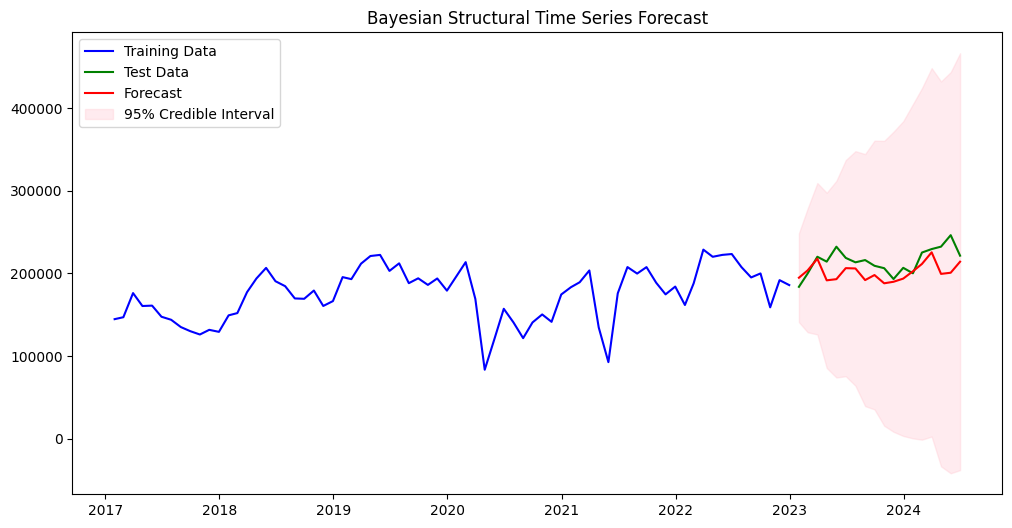

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train_ts.index, train_ts.values, label='Training Data', color='blue')
plt.plot(test_ts.index, test_ts.values, label='Test Data', color='green')
plt.plot(
    test_ts.index,
    forecast_mean,
    label='Forecast',
    color='red'
)
plt.fill_between(
    test_ts.index,
    forecast_mean - 2 * forecast_std,
    forecast_mean + 2 * forecast_std,
    color='pink',
    alpha=0.3,
    label='95% Credible Interval'
)
plt.title('Bayesian Structural Time Series Forecast')
plt.legend()
plt.show()